<a href="https://colab.research.google.com/github/olkaand/uczenie_maszynowe/blob/use_case3/Case_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treść zadania

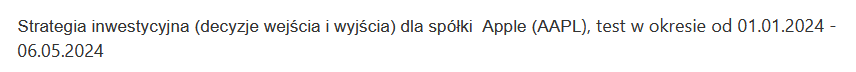

# Pakiety

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [ ]:
# importing libraries for learning
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam

In [ ]:
! pip install backtesting

from backtesting import Backtest
from backtesting import Strategy
#from backtesting import TrailingStrategy
from backtesting.lib import crossover
from backtesting.test import SMA
from backtesting.lib import SignalStrategy, TrailingStrategy
from backtesting import *

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '
/usr/local/lib/python3.10/dist-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  return pd.read_csv(join(dirname(__file__), filename),
/usr/local/lib/python3.10/dist-packages/backtesting/test/__init__.py:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-cons

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install ffn
import ffn # http://pmorissette.github.io/ffn/index.html

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.stats.diagnostic import acorr_ljungbox

!pip install simpful
import simpful as sf
from simpful import *


In [ ]:
! pip install ta

from ta.trend import MACD
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=1d80d0d827d84f868f35d2d4a20f0ec1a4fd73598b5738d4e661ac6b4d84b23b
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 1.7 MB/s eta 0:00:00


# Wgranie, przegląd i przygotowanie danych

## Dane testowe

In [ ]:
#the start and end date
start_date = dt.datetime(2024,1,1)
end_date = dt.datetime(2024,5,6)

#loading from yahoo finance
data = yf.download("AAPL",start_date, end_date)

data.head(10)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-02,187.149994,188.440002,183.889999,185.639999,185.403412,82488700
2024-01-03,184.220001,185.880005,183.429993,184.250000,184.015198,58414500
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.678177,71983600
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.949097,62303300
2024-01-08,182.089996,185.600006,181.500000,185.559998,185.323517,59144500
2024-01-09,183.919998,185.149994,182.729996,185.139999,184.904053,42841800
2024-01-10,184.350006,186.399994,183.919998,186.190002,185.952713,46792900
2024-01-11,186.539993,187.050003,183.619995,185.589996,185.353485,49128400
2024-01-12,186.059998,186.740005,185.190002,185.919998,185.683060,40444700


In [ ]:
data.describe().round(2)

,Open,High,Low,Close,Adj Close,Volume
count,86.00,86.00,86.00,86.00,86.00,8.600000e+01
mean,178.49,179.97,177.01,178.47,178.40,6.203684e+07
std,8.41,8.29,8.21,8.41,8.33,2.170747e+07
min,165.35,166.40,164.08,165.00,165.00,3.742550e+07
25%,170.62,172.33,169.46,170.17,170.17,4.815025e+07
50%,178.30,179.60,176.24,179.17,179.17,5.501865e+07
75%,185.24,186.66,183.49,185.45,185.25,6.943685e+07
max,195.42,196.38,194.34,195.18,194.93,1.632241e+08


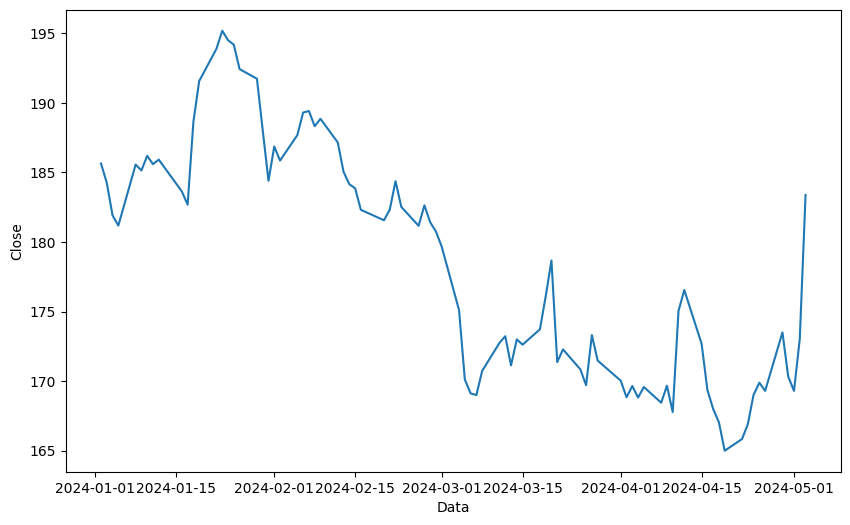

In [ ]:
#wykres danych do testowania
test_data = data.loc[(data.index >= start_date) & (data.index <= end_date)]
plt.figure(figsize=(10, 6))
plt.plot(test_data['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

## Dane treningowe z 3 lat

[*********************100%%**********************]  1 of 1 completed


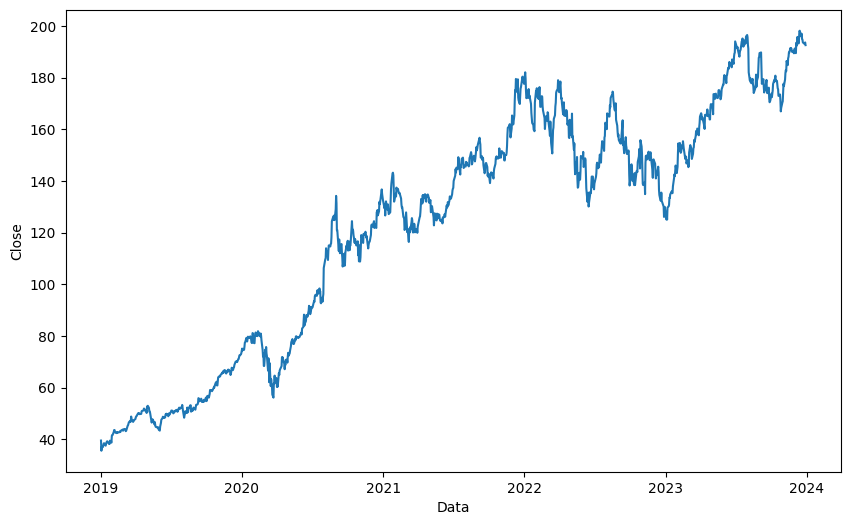

In [ ]:
start_date_tr = dt.datetime(2019,1,1)
end_date_tr = dt.datetime(2024,1,1)

data_tr = yf.download("AAPL",start_date_tr, end_date_tr)

#wykres dla danych treningowych
train_data = data_tr.loc[(data_tr.index >= start_date_tr) & (data_tr.index <= end_date_tr)]
plt.figure(figsize=(10, 6))
plt.plot(data_tr['Close'])
plt.xlabel('Data')
plt.ylabel('Close')
plt.show()

## Zwroty dla danych testowych

In [ ]:
data['returns'] = data['Close'].to_log_returns()
data = data.dropna()
data.head()

,Open,High,Low,Close,Adj Close,Volume,returns
Date,,,,,,,
2024-01-03,184.220001,185.880005,183.429993,184.250000,184.015198,58414500,-0.007516
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.678177,71983600,-0.012781
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.949097,62303300,-0.004021
2024-01-08,182.089996,185.600006,181.500000,185.559998,185.323517,59144500,0.023887
2024-01-09,183.919998,185.149994,182.729996,185.139999,184.904053,42841800,-0.002266


### Rozkład zwrotów

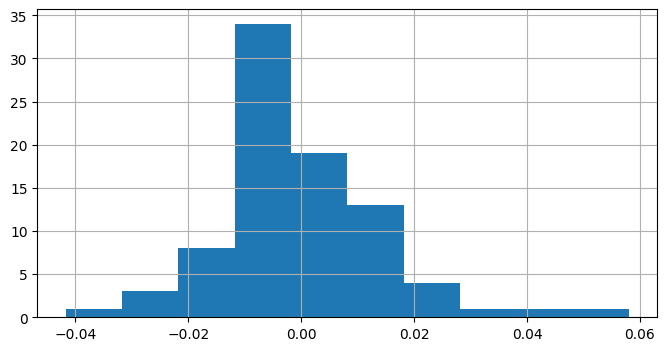

In [ ]:
ax = data['returns'].hist(figsize=(8, 4))

Więcej zwrotów ujemnych niż zwrotów dodatnich

## Porównanie z indeksem NASDAQ

NASDAQ Composite to indeks ważony kapitalizacją obliczany dla ok. 3000 akcji notowanych na giełdzie NASDAQ. Indeks uwzględnia wszelkie akcje notowane na giełdzie NASDAQ, które nie są instrumentami pochodnymi, akcjami preferencyjnymi, funduszami, ETF-ami bądź papierami dłużnymi. Akcje Apple Inc. (AAPL) są notowane w indeksie Nasdaq Composite (IXIC)

In [ ]:
df = ffn.get('^IXIC:Close, AAPL:Close', start=start_date_tr, end=end_date_tr)

yfinance: pandas_datareader support is deprecated & semi-broken so will be removed in a future verison. Just use yfinance.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [ ]:
returns = df.to_log_returns().dropna()
print(returns.head())

            ixicclose  aaplclose
Date                            
2019-01-03  -0.030840  -0.104924
2019-01-04   0.041720   0.041803
2019-01-07   0.012477  -0.002228
2019-01-08   0.010718   0.018884
2019-01-09   0.008673   0.016839


In [ ]:
df.head()

,ixicclose,aaplclose
Date,,
2019-01-02,6665.939941,39.480000
2019-01-03,6463.500000,35.547501
2019-01-04,6738.859863,37.064999
2019-01-07,6823.470215,36.982498
2019-01-08,6897.000000,37.687500


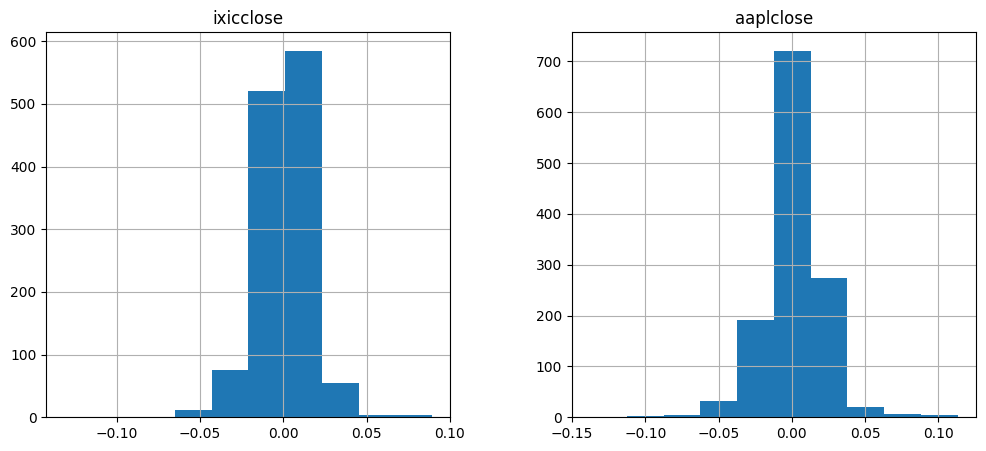

In [ ]:
ax2 = returns.hist(figsize=(12, 5))

In [ ]:
returns.corr().as_format('.2f')

,ixicclose,aaplclose
ixicclose,1.00,0.85
aaplclose,0.85,1.00


Szaregi są dosyć mocno skorelowane ze sobą

<Axes: xlabel='Date'>

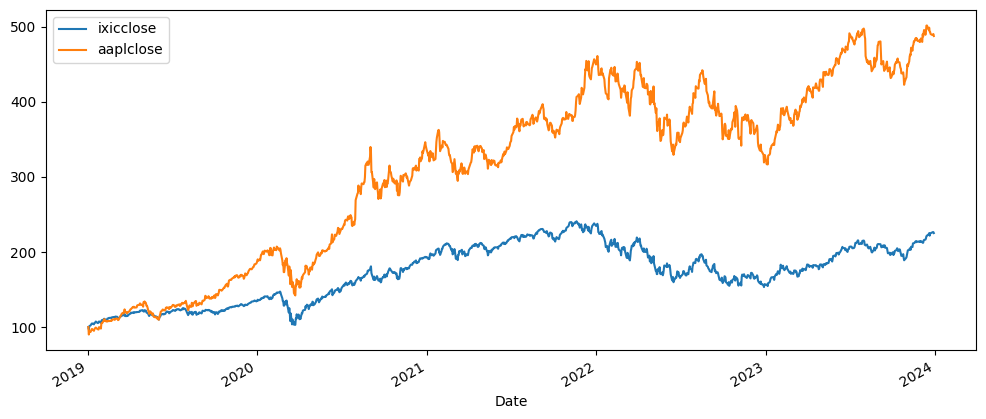

In [ ]:
df.rebase().plot(figsize=(12,5))

Występuje dosyć duża korelacja. Wykres pokazuje względne zmiany cen zamknięcia indeksu Nasdaq Composite i akcji Apple Inc. Początkowe wartości obu serii danych zostały ustawione na 100, co pozwala na łatwe porównanie, jak obie wartości zmieniały się w czasie w stosunku do siebie.


In [ ]:
perf = df.calc_stats()
perf['aaplclose'].stats

start                    2019-01-02 00:00:00
end                      2023-12-29 00:00:00
rf                                       0.0
total_return                        3.876646
cagr                                0.373869
max_drawdown                       -0.314273
calmar                              1.189632
mtd                                 0.013583
three_month                         0.124525
six_month                           0.015507
ytd                                 0.481798
one_year                            0.485456
three_year                          0.126064
five_year                           0.373869
ten_year                                 NaN
incep                               0.373869
daily_sharpe                        1.146995
daily_sortino                       1.916398
daily_mean                          0.369823
daily_vol                           0.322428
daily_skew                         -0.041896
daily_kurt                          5.242295
best_day  

Interpretacja przykładowych statystyk:


*   Całkowity zwrot: 3.876646
*   Skumulowany roczny wskaźnik wzrostu: 0.373869
*   Maksymalny spadek wartości: -0.314273
*   Miesięczna zmienność: 0.301233
*   Miesięczna średnia: 0.359535


In [ ]:
returns['Skumulowane_aapl'] = returns['aaplclose'].cumsum()+ 100
returns['Skumulowane_aapl'].iloc[0] = 100

perm= ffn.core.PerformanceStats(returns['Skumulowane_aapl'], rf=0.0)
perm.display()

Stats for Skumulowane_aapl from 2019-01-03 00:00:00 - 2023-12-29 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
1.58%                  1  0.32%   -0.37%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y    incep.
-----  -----  -----  -----  -----  -----  -----  -----  --------
0.01%  0.12%  0.02%  0.39%  0.39%  0.12%  0.32%  -      0.32%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.00     1.06       0.62
mean    0.32%    0.31%      0.24%
vol     0.32%    0.29%      0.39%
skew    -0.19    -0.27      -1.37
kurt    5.24     -0.90      2.34
best    0.11%    0.19%      0.59%
worst   -0.14%   -0.14%     -0.31%

Drawdowns:
max     avg       # days
------  ------  --------
-0.37%  -0.04%     24.09

Misc:
---------------  ------
avg. up month    0.08%
avg. down month  -0.07%
up year %        75.00%
12m up %         85.

Dla wygody odczytywania, skumulowane zwroty są powiększone o 100

In [ ]:
returns.head()

,ixicclose,aaplclose,Skumulowane_aapl
Date,,,
2019-01-03,-0.030840,-0.104924,100.000000
2019-01-04,0.041720,0.041803,99.936879
2019-01-07,0.012477,-0.002228,99.934651
2019-01-08,0.010718,0.018884,99.953534
2019-01-09,0.008673,0.016839,99.970373


In [ ]:
returns['lag_aapl'] = returns['aaplclose'].shift(1)
returns

,ixicclose,aaplclose,Skumulowane_aapl,lag_aapl
Date,,,,
2019-01-03,-0.030840,-0.104924,100.000000,NaN
2019-01-04,0.041720,0.041803,99.936879,-0.104924
2019-01-07,0.012477,-0.002228,99.934651,0.041803
2019-01-08,0.010718,0.018884,99.953534,-0.002228
2019-01-09,0.008673,0.016839,99.970373,0.018884
...,...,...,...,...
2023-12-22,0.001943,-0.005563,101.590000,-0.000770
2023-12-26,0.005428,-0.002845,101.587155,-0.005563
2023-12-27,0.001631,0.000518,101.587673,-0.002845


In [ ]:
lag_aapl_corr = returns[['ixicclose', 'lag_aapl']]
lag_aapl_corr=lag_aapl_corr.dropna()
lag_aapl_corr.corr().as_format('.2f')

,ixicclose,lag_aapl
ixicclose,1.00,-0.17
lag_aapl,-0.17,1.00


Występuje mała, ujemna, odwrotna korelacja między cenami zamknięcia IXIC i opóźnieniami w AAPL

## Sprawdzenie przyczynowości

In [ ]:
my_data = pd.DataFrame({'NASDAQ': returns['ixicclose'], 'AAPL': returns['aaplclose']})

# Wybór modelu VAR
model = VAR(my_data)
results = model.fit(maxlags=1, ic='aic')

print(results.summary())

# Test Ljung-Boxa
ljung_box_nasdaq = acorr_ljungbox(results.resid['NASDAQ'])
print(f"Ljung-Box test for NASDAQ: {ljung_box_nasdaq}")

ljung_box_aapl = acorr_ljungbox(results.resid['AAPL'])
print(f"Ljung-Box test for AAPL: {ljung_box_aapl}")

# Test stabilności
stability_test = results.test_causality('NASDAQ', 'AAPL', kind='f')
print(stability_test.summary())

stability_test_2 = results.test_causality('AAPL', 'NASDAQ', kind='f')
print(stability_test_2.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 16, Jun, 2024
Time:                     18:28:15
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -17.4037
Nobs:                     1256.00    HQIC:                  -17.4191
Log likelihood:           7386.58    FPE:                2.69771e-08
AIC:                     -17.4283    Det(Omega_mle):     2.68487e-08
--------------------------------------------------------------------
Results for equation NASDAQ
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.000835         0.000443            1.885           0.059
L1.NASDAQ        -0.040881         0.052941           -0.772           0.440
L1.AAPL          -0.108293         0.041442           -2.613           0.00

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Mała, ujemna korelacja (-0.08) między cenami zamknięcia IXIC i opóźnionymi zwrotami AAPL sugeruje, że zmiany w indeksie NASDAQ mogą wpływać na przyszłe zwroty AAPL w niewielkim stopniu, ale w odwrotnym kierunku.

AAPL wpływa na NASDAQ na poziomie istotności 5%, co oznacza, że zwroty AAPL mogą przewidywać przyszłe zmiany w NASDAQ, natomiast NASDAQ nie wpływa na AAPL, co sugeruje, że zmiany w NASDAQ nie są dobrym wskaźnikiem przyszłych zwrotów AAPL.

Wyniki testów Ljung-Box dla NASDAQ i AAPL wskazują na obecność autokorelacji w szeregach czasowych, co oznacza, że przeszłe wartości mają wpływ na przyszłe wartości w danych.

# Model LSTM

Long Short-Term Memory (LSTM) to rodzaj rekurencyjnej sieci neuronowej, która jest wyjątkowa dzięki swojej zdolności do zapamiętywania „długoterminowych” zależności.

In [ ]:
# Przygotowanie danych
prices_train = data_tr["Close"].values.reshape(-1, 1)  # konwersja do tablicy numpy
prices_test = data["Close"].values.reshape(-1, 1)

# Przeskalowanie do zakresu [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_prices_train = scaler.fit_transform(prices_train)
scaled_prices_test = scaler.transform(prices_test)

# Tworzenie sekwencji danych dla modelu LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Określenie długości sekwencji (liczba kroków wstecznych)
sequence_length = 10 # ile dni bierzemy pod uwagę do predykcji

# Utworzenie sekwencji danych treningowych i testowych
X_train, y_train = create_sequences(scaled_prices_train, sequence_length)
X_test, y_test = create_sequences(scaled_prices_test, sequence_length)

print("Rozmiar danych treningowych:", X_train.shape, y_train.shape)
print("Rozmiar danych testowych:", X_test.shape, y_test.shape)

Rozmiar danych treningowych: (1248, 10, 1) (1248, 1)
Rozmiar danych testowych: (75, 10, 1) (75, 1)


In [ ]:
# Model LSTM z hiperparametryzacją
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

input_shape = (X_train.shape[1], X_train.shape[2])  # Kształt danych wejściowych dla modelu LSTM
lstm_model = create_lstm_model(input_shape)

# Trenowanie
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Predykcja cen dla danych testowych
predicted_prices = lstm_model.predict(X_test)

Epoch 1/100
32/32 [==============================] - 13s 172ms/step - loss: 0.0401 - val_loss: 0.0060
Epoch 2/100
32/32 [==============================] - 1s 24ms/step - loss: 0.0024 - val_loss: 9.7002e-04
Epoch 3/100
32/32 [==============================] - 1s 30ms/step - loss: 9.3287e-04 - val_loss: 9.3888e-04
Epoch 4/100
32/32 [==============================] - 1s 29ms/step - loss: 8.6142e-04 - val_loss: 0.0012
Epoch 5/100
32/32 [==============================] - 1s 29ms/step - loss: 8.7088e-04 - val_loss: 0.0013
Epoch 6/100
32/32 [==============================] - 1s 28ms/step - loss: 8.4660e-04 - val_loss: 9.2695e-04
Epoch 7/100
32/32 [==============================] - 1s 27ms/step - loss: 8.4524e-04 - val_loss: 0.0011
Epoch 8/100
32/32 [==============================] - 1s 32ms/step - loss: 8.5831e-04 - val_loss: 0.0016
Epoch 9/100
32/32 [==============================] - 1s 24ms/step - loss: 8.5027e-04 - val_loss: 8.2937e-04
Epoch 10/100
32/32 [==============================] - 

In [ ]:
mse = mean_squared_error(y_test, predicted_prices)
print("Mean Squared Error (MSE) na danych testowych:", mse.round(5))

Mean Squared Error (MSE) na danych testowych: 0.00047


In [ ]:
predicted_prices_unscaled = scaler.inverse_transform(predicted_prices)

In [ ]:
# Dodanie przewidywanych cen do testowych danych
data['Predicted_Close'] = np.nan
data['Predicted_Close'].iloc[sequence_length:] = predicted_prices_unscaled.flatten()

In [ ]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,returns,Predicted_Close
Date,,,,,,,,
2024-01-03,184.220001,185.880005,183.429993,184.250000,184.015198,58414500,-0.007516,NaN
2024-01-04,182.149994,183.089996,180.880005,181.910004,181.678177,71983600,-0.012781,NaN
2024-01-05,181.990005,182.759995,180.169998,181.179993,180.949097,62303300,-0.004021,NaN
2024-01-08,182.089996,185.600006,181.500000,185.559998,185.323517,59144500,0.023887,NaN
2024-01-09,183.919998,185.149994,182.729996,185.139999,184.904053,42841800,-0.002266,NaN


## Sygnały kupna i sprzedaży

OPCJA I

In [ ]:
data['Signal'] = 0

for i in range(sequence_length, len(data) - 1):
    today_close = data['Close'].iloc[i]
    tomorrow_predicted_close = data['Predicted_Close'].iloc[i + 1]

    if tomorrow_predicted_close > today_close:
        data['Signal'].iloc[i + 1] = 1  # Kup
    elif tomorrow_predicted_close < today_close:
       data['Signal'].iloc[i + 1] = -1  # Sprzedaj
    else:
        data['Signal'].iloc[i + 1] = 0  # Brak zmiany

OPCJA II

Tu były sprwadzane różne opóźnienia, to najlepsze było dla 5 dni

In [ ]:
#data['Signal'] = 0

# Przewidywane ceny zamknięcia za 5 dni
#future_predicted_close = data['Predicted_Close'].shift(-5)

#for i in range(sequence_length, len(data) - 5):  # zmiana z len(test_data) - 1 na len(test_data) - 5
#    today_close = data['Close'].iloc[i]
#    tomorrow_predicted_close = future_predicted_close.iloc[i]

#    if tomorrow_predicted_close > today_close:
#        data['Signal'].iloc[i + 5] = 1  # Kup
#    elif tomorrow_predicted_close < today_close:
#        data['Signal'].iloc[i + 5] = -1  # Sprzedaj
#    else:
#        data['Signal'].iloc[i + 5] = 0  # Brak zmiany

# Wskażnik analizy technicznej

In [ ]:
macd_indicator = ta.trend.MACD(data['Close'])

# Łączenie z ramką danych
data['macd'] = macd_indicator.macd()
data['macd_signal'] = macd_indicator.macd_signal()

# Różnica potrzebna do sygnałów
data['macd_diff'] = data['macd'] - data['macd_signal']

# Domyśnie HOLD
data['signal_MACD'] = 0

# Kupno (MACD > sygnał)
data.loc[data['macd_diff'] > 0, 'signal_MACD'] = 1

# Sprzedaż (MACD < sygnał)
data.loc[data['macd_diff'] < 0, 'signal_MACD'] = -1


# Strategie

## Tylko z modelu LSTM

In [ ]:
class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.066975
    ttp = 0.060409
    size_tr = 0.878244
    def init(self):
        super().init()
        self.signal = self.I(lambda x: data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

bt = Backtest(data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1],
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]

Start                     2024-01-03 00:00:00
End                       2024-05-03 00:00:00
Duration                    121 days 00:00:00
Exposure Time [%]                   85.882353
Equity Final [$]                 10929.328059
Equity Peak [$]                  11249.000609
Return [%]                           9.293281
Buy & Hold Return [%]               -0.472182
Return (Ann.) [%]                   30.142236
Volatility (Ann.) [%]               14.170784
Sharpe Ratio                         2.127069
Sortino Ratio                        5.985637
Calmar Ratio                        10.312978
Max. Drawdown [%]                   -2.922748
Avg. Drawdown [%]                   -1.366431
Max. Drawdown Duration       57 days 00:00:00
Avg. Drawdown Duration       15 days 00:00:00
# Trades                                    9
Win Rate [%]                        44.444444
Best Trade [%]                       7.003484
Worst Trade [%]                    -12.991806
Avg. Trade [%]                    

Backtest.optimize:   0%|          | 0/1000 [00:00<?, ?it/s]

ttp       ssl       size_tr 
0.064227  0.059610  0.978956    11608.880449
0.064249  0.035522  0.981927    11609.324722
0.064252  0.049209  0.980960    11609.381609
Name: Equity Final [$], dtype: float64

In [ ]:
stats_skopt

Start                     2024-01-03 00:00:00
End                       2024-05-03 00:00:00
Duration                    121 days 00:00:00
Exposure Time [%]                   85.882353
Equity Final [$]                 11609.381609
Equity Peak [$]                  11609.381609
Return [%]                          16.093816
Buy & Hold Return [%]               -0.472182
Return (Ann.) [%]                   55.646687
Volatility (Ann.) [%]               25.443029
Sharpe Ratio                         2.187109
Sortino Ratio                        6.208102
Calmar Ratio                        11.212527
Max. Drawdown [%]                   -4.962903
Avg. Drawdown [%]                     -1.9213
Max. Drawdown Duration       32 days 00:00:00
Avg. Drawdown Duration       11 days 00:00:00
# Trades                                    8
Win Rate [%]                             62.5
Best Trade [%]                       7.383843
Worst Trade [%]                     -9.524507
Avg. Trade [%]                    

## Strategia z uwzględnieniem MACD

In [ ]:
class LSTMCustomStrategy(SignalStrategy):
    ssl = 0.066975
    ttp = 0.060409
    size_tr = 0.878244

    def init(self):
        super().init()
        close_series = pd.Series(self.data.Close)  # Convert to Pandas Series
        self.macd_decision = self.I(lambda x: data['signal_MACD'], 'signal_MACD')
        self.signal = self.I(lambda x: data['Signal'], 'signal')

    def next(self):
        close = self.data.Close
        signal = self.signal
        macd_decision = self.macd_decision
        upper_tp = close * (1 + self.ttp)
        upper_sl = close * (1 + self.ssl)
        lower_sl = close * (1 - self.ssl)
        lower_tp = close * (1 - self.ttp)

        if signal == 1 or macd_decision == 1 and not self.position.is_long:
            self.buy(size=self.size_tr, sl=lower_sl, tp=upper_tp)
        elif signal == -1 or macd_decision == -1 and not self.position.is_short:
            self.sell(size=self.size_tr, sl=upper_sl, tp=lower_tp)

bt = Backtest(data, LSTMCustomStrategy, cash=10000, commission=0.002, trade_on_close=False, hedging=False)
stats = bt.run()
bt.plot()
print(stats)

# # Optymalizacja parametrów
stats_skopt, heatmap, optimize_result = bt.optimize(
    ttp=[0.01, 0.1],
    ssl=[0.01, 0.1],
    size_tr=[0.4, 1],
    maximize='Equity Final [$]',
    method='skopt',
    max_tries=1000,
    random_state=10,
    return_heatmap=True,
    return_optimization=True
)
heatmap.sort_values().iloc[-3:]

In [ ]:
stats_skopt

Lepsze wyniki daje strategia z uwzględnieniem MACD. Dnia 16.06, po ponowynym uruchomieniu kodu, zwrot z inwestycji wyniósł tylko 15%, natomiast w dniu 8.06 zwrot był na poziomie 41%. Załączony jest screen wyniku z tego dnia. Niestety nie wiem co spowodowało tak duży spadek

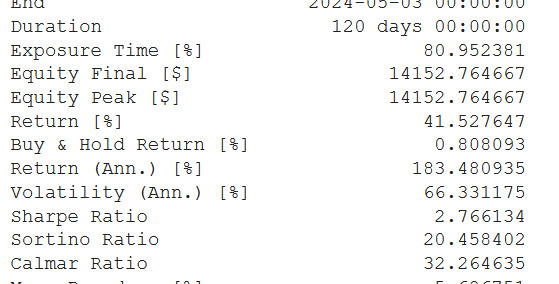